## Using H1 fullsim as input

Trying out things from Ben Nachman's example.

This uses the H1 fullsim MC as input.

Uses set of variables is E, pt, pz, Empz (redundant but useful?) for both HFS and electron as well as delta phi between HFS and electron.

Working on increasing training statistics for better results.

### With small stats (1e6)

learning_rate of 1e-4 is ok

### With 2e7 max on h1-fullsim-allfiles.root

learning_rate of 1e-4 is ok, with more events, did a bit better than smaller training sample but not by much.





In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3

import matplotlib as mpl



/Users/owen/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:

#--- Number of events to use in training.
#max_events = 2e7
#max_events = 2e6
max_events = 4e7


#--- Hyperparameter settings.
#learning_rate_setval = 1e-4
#batch_size_setval = 128
#max_epochs = 5000


#learning_rate_setval = 1e-4
#batch_size_setval = 64
#max_epochs = 5000

learning_rate_setval = 1e-4
batch_size_setval = 1024
max_epochs = 5000


In [3]:
%%time

#input_file = 'h1-fullsim-2021-07-19/h1fullsim-5files.root'
input_file = 'h1-fullsim-2021-07-19/h1-fullsim-allfiles.root'

ur_file = uproot3.open(input_file)

print (ur_file.keys()) 
ur_tree = ur_file['Django/minitree']
print(ur_tree)
ur_tree.show()

#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=2e7,flatten=True)
pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

[b'Django;1']
<TTree b'minitree' at 0x0001058be6d0>
wgt                        (no streamer)              asdtype('>f4')
y_e                        (no streamer)              asdtype('>f4')
Q2_e                       (no streamer)              asdtype('>f4')
y_sigma                    (no streamer)              asdtype('>f4')
Q2_sigma                   (no streamer)              asdtype('>f4')
y_esigma                   (no streamer)              asdtype('>f4')
Q2_esigma                  (no streamer)              asdtype('>f4')
y_da                       (no streamer)              asdtype('>f4')
Q2_da                      (no streamer)              asdtype('>f4')
y_h                        (no streamer)              asdtype('>f4')
Q2_h                       (no streamer)              asdtype('>f4')
gen_x                      (no streamer)              asdtype('>f4')
gen_y                      (no streamer)              asdtype('>f4')
gen_Q2                     (no streamer)           

In [4]:
%%time

pandas_df.eval( 'gene_e = sqrt( gene_px*gene_px + gene_py*gene_py + gene_pz*gene_pz)', inplace=True )

pandas_df.eval( 'e_e = sqrt( e_px*e_px + e_py*e_py + e_pz*e_pz)', inplace=True )

pandas_df.eval( 'e_pt = sqrt( e_px*e_px + e_py*e_py)', inplace=True )

pandas_df.eval( 'e_phi = arctan2( e_py, e_px )', inplace=True )

pandas_df.eval( 'gene_pt = sqrt( gene_px*gene_px + gene_py*gene_py)', inplace=True )
pandas_df.eval( 'gene_phi = arctan2( gene_py, gene_px )', inplace=True )

pandas_df.eval( 'HFS_phi = arctan2( HFS_py, HFS_px )', inplace=True )
pandas_df.eval( 'HFS_pt = sqrt( HFS_px*HFS_px + HFS_py*HFS_py)', inplace=True )

pandas_df.eval( 'dphi = e_phi - HFS_phi', inplace=True )
pandas_df.eval( 'dphi = (abs(dphi)<3.14159265)*(dphi)+(dphi>3.14159265)*(dphi-2*3.14159265) + (dphi<-3.14159265)*(dphi+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi = (dphi>0)*dphi + (dphi<0)*(dphi+2*3.14159265)', inplace=True )


pandas_df.eval( 'gen_dphi = 3.141592653589793', inplace=True )

pandas_df.eval( 'HFS_Empz = HFS_E - HFS_pz', inplace=True )
pandas_df.eval( 'e_Empz = e_e - e_pz', inplace=True )

pandas_df.eval( 'gene_Empz = gene_e - gene_pz', inplace=True )

pandas_df.eval( 's = 4*27.6*920', inplace=True)
pandas_df.eval( 'gen_x = gen_Q2/(s*gen_y)', inplace=True)

CPU times: user 10.8 s, sys: 19 s, total: 29.8 s
Wall time: 33.7 s


## Do some cleaning

In [5]:
%%time

temp = pandas_df.query('Empz>45')
pandas_df = temp
temp = pandas_df.query('gen_y > 0 and gen_y < 1.0')
pandas_df = temp

CPU times: user 12.4 s, sys: 46.1 s, total: 58.4 s
Wall time: 1min 16s


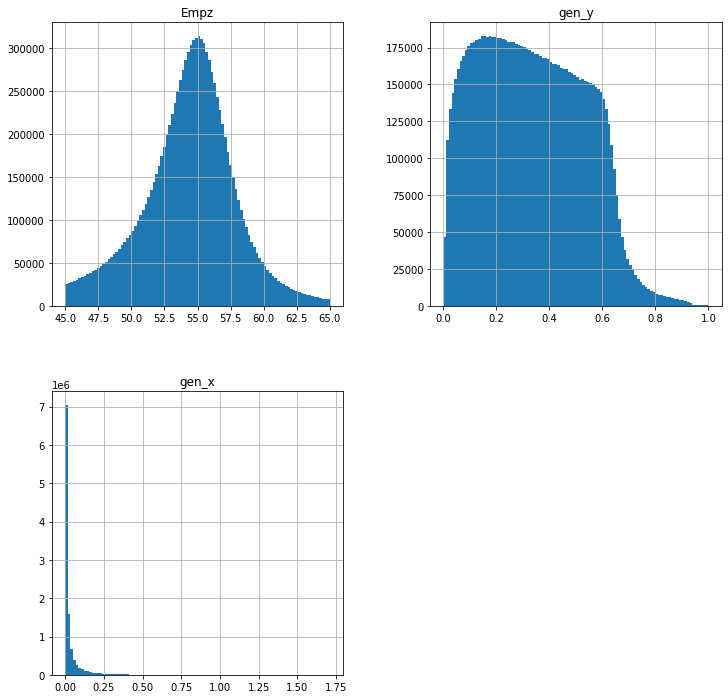

In [6]:
pandas_df.hist(figsize=(12,12), bins=100, column=['Empz','gen_y','gen_x'])
plt.show()

In [7]:
pandas_df

,wgt,y_e,Q2_e,y_sigma,Q2_sigma,y_esigma,Q2_esigma,y_da,Q2_da,y_h,...,gene_pt,gene_phi,HFS_phi,HFS_pt,dphi,gen_dphi,HFS_Empz,e_Empz,gene_Empz,s
entry,,,,,,,,,,,,,,,,,,,,,
9,0.008617,0.084392,1877.214722,0.087820,1884.270386,0.087491,1877.214722,0.086757,1872.364868,0.088150,...,42.024578,1.379465,-1.771349,42.015118,3.150502,3.141593,4.865891,50.541573,51.081085,101568.0
13,0.008617,0.597157,885.630615,0.621432,942.419250,0.583985,885.630615,0.630583,812.146057,0.661279,...,18.043825,0.401690,-2.323327,18.164295,2.724788,3.141593,36.502609,22.236927,21.011444,101568.0
20,0.008617,0.171546,1309.299072,0.068047,1163.892822,0.076548,1309.299072,0.136541,1364.621338,0.060490,...,33.622746,2.096463,-1.322390,15.206989,3.418535,3.141593,3.339027,45.730652,47.131447,101568.0
21,0.071911,0.196490,279.604614,0.092119,247.460953,0.104085,279.604614,0.084321,318.636963,0.081529,...,14.780707,-1.171766,1.955483,16.515541,3.156560,3.141593,4.500389,44.353752,43.702736,101568.0
22,0.008617,0.692239,14469.998047,0.668255,13423.892578,0.720331,14469.998047,0.666726,15669.503906,0.619944,...,70.459167,-2.140570,0.999157,67.194351,3.149307,3.141593,34.220890,16.988434,18.121147,101568.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39999989,0.022525,0.348858,164.726440,0.253866,143.754593,0.290901,164.726440,0.284016,181.130341,0.221545,...,10.342019,-0.236296,2.839654,8.883149,3.205634,3.141593,12.229288,35.943024,35.902695,101568.0
39999992,0.027724,0.033545,252.931671,0.093156,269.557953,0.087410,252.931671,0.090151,238.117233,0.099279,...,14.714071,-0.593284,2.454410,16.209393,3.235561,3.141593,5.480225,53.348309,49.869545,101568.0
39999993,0.009713,0.434357,118.796310,0.442931,120.624855,0.436217,118.796310,0.742140,54.155605,0.449749,...,7.951761,2.557605,0.615278,2.264632,1.945792,3.141593,24.826126,31.223515,30.294907,101568.0


## Set up machine learning stuff

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#-- Ben suggested to try this.  2021-08-07
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=10,
               verbose=True,
               restore_best_weights=True)

import os

#os.environ['CUDA_VISIBLE_DEVICES']="0"

print(tf.config.list_physical_devices())

#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices = tf.config.list_physical_devices('CPU') 




[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Test with gen electron vars only

Should be a slam dunk.

In [9]:
X = np.c_[ 
          pandas_df['gene_pz'].to_numpy(),
          pandas_df['gene_e'].to_numpy(),
          pandas_df['gene_pt'].to_numpy(),
          pandas_df['gene_Empz'].to_numpy(),
         ]

Y = pandas_df['gen_x'].to_numpy()

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Y = Y.reshape(-1,1)
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

GY = pandas_df['gen_y'].to_numpy()

print('\n\n Shape of X')
print( X.shape )

print('\n\n Shape of Y')
print( Y.shape )



 Shape of X
(10957856, 4)


 Shape of Y
(10957856, 1)


In [10]:
X_train, X_test, Y_train, Y_test, GY_train, GY_test = train_test_split( X, Y, GY, test_size=0.5)

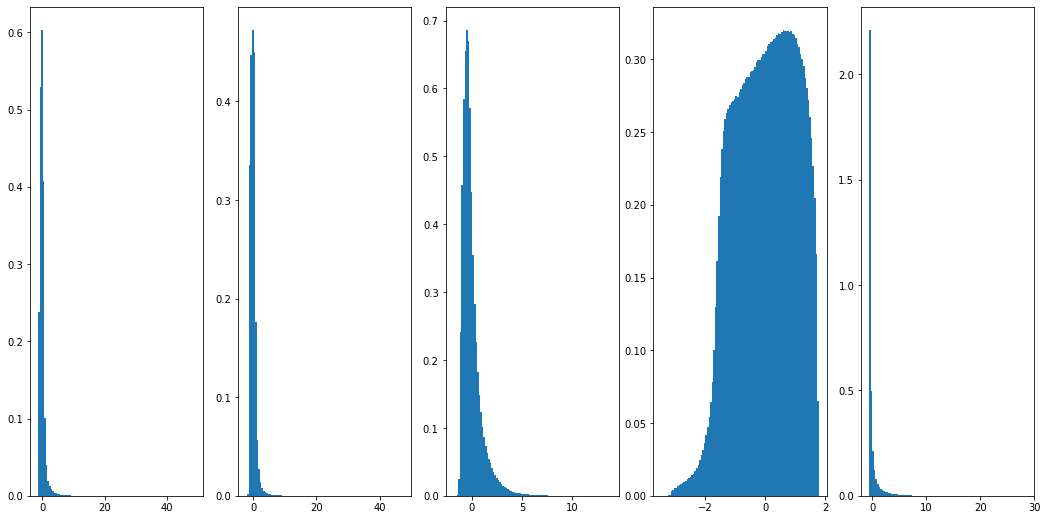

In [11]:
fig,ax = plt.subplots(1,5,figsize=(18,9))
for i in range(4):
    ax[i].hist( X[:,i],density=True,bins=100)

ax[4].hist( Y[:,0],density=True,bins=100)
plt.show()

In [12]:
model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='selu'))
model.add(Dense(1, activation='linear'))

#opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval)
myloss = tf.keras.losses.Huber()

model.compile(loss=myloss, optimizer=opt, metrics=['accuracy'])

In [13]:
%%time

hist = model.fit(
    X_train, Y_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X_test,Y_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
5351/5351 [==============================] - 21s 4ms/step - loss: 0.0594 - accuracy: 0.0000e+00 - val_loss: 0.0232 - val_accuracy: 0.0000e+00
Epoch 2/5000
5351/5351 [==============================] - 20s 4ms/step - loss: 0.0257 - accuracy: 0.0000e+00 - val_loss: 0.0164 - val_accuracy: 0.0000e+00
Epoch 3/5000
5351/5351 [==============================] - 21s 4ms/step - loss: 0.0199 - accuracy: 0.0000e+00 - val_loss: 0.0152 - val_accuracy: 0.0000e+00
Epoch 4/5000
5351/5351 [==============================] - 23s 4ms/step - loss: 0.0180 - accuracy: 0.0000e+00 - val_loss: 0.0148 - val_accuracy: 0.0000e+00
Epoch 5/5000
5351/5351 [==============================] - 31s 6ms/step - loss: 0.0170 - accuracy: 0.0000e+00 - val_loss: 0.0145 - val_accuracy: 0.0000e+00
Epoch 6/5000
5351/5351 [==============================] - 31s 6ms/step - loss: 0.0164 - accuracy: 0.0000e+00 - val_loss: 0.0145 - val_accuracy: 0.0000e+00
Epoch 7/5000
5351/5351 [==============================] - 27s 5ms/step

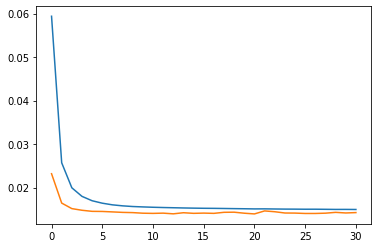

In [14]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [15]:
mypreds = model.predict(X_test,batch_size=1000)

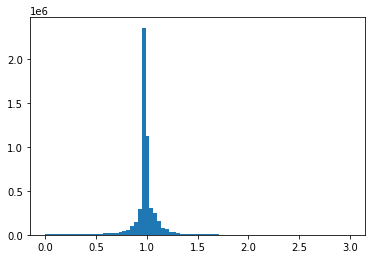

In [16]:
_,_,_=plt.hist(mypreds[:,0]/Y_test[:,0],bins=np.linspace(0,3,80))

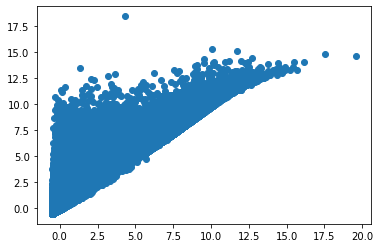

In [17]:
plt.scatter(mypreds[:,0],Y_test[:,0])

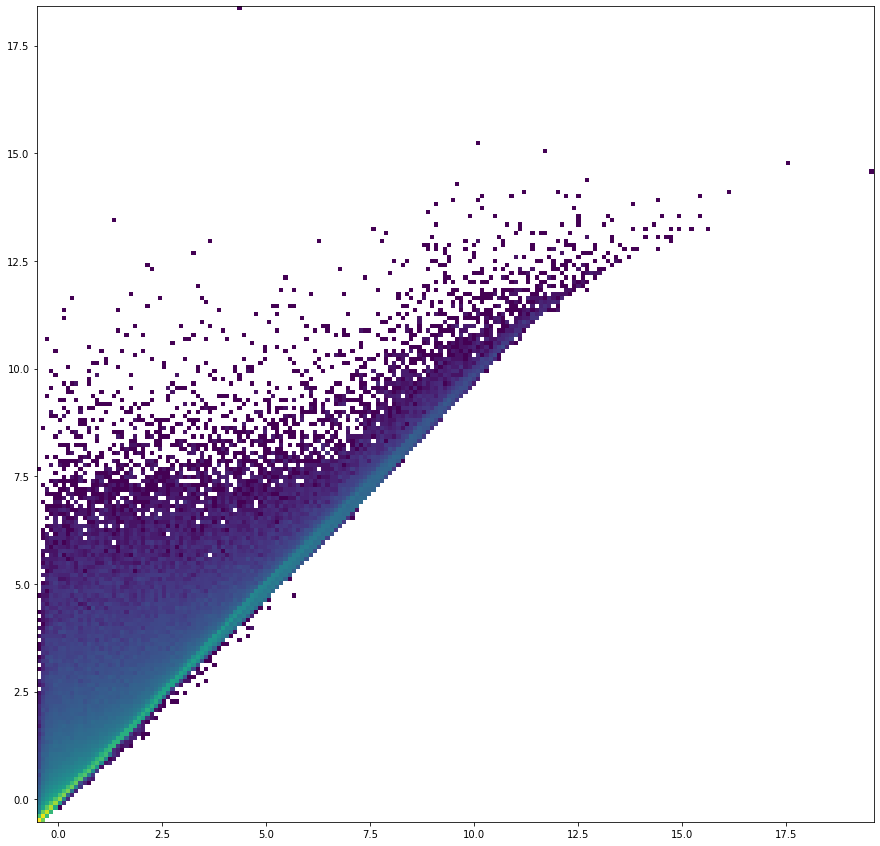

In [18]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.hist2d(mypreds[:,0],Y_test[:,0],bins=200, norm=mpl.colors.LogNorm())
plt.show()

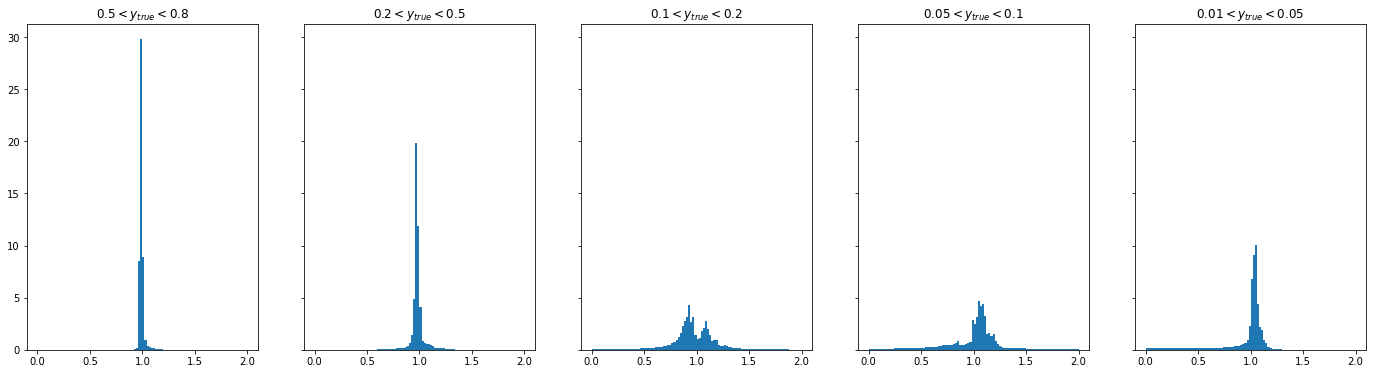

In [19]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(mypreds[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

plt.show()



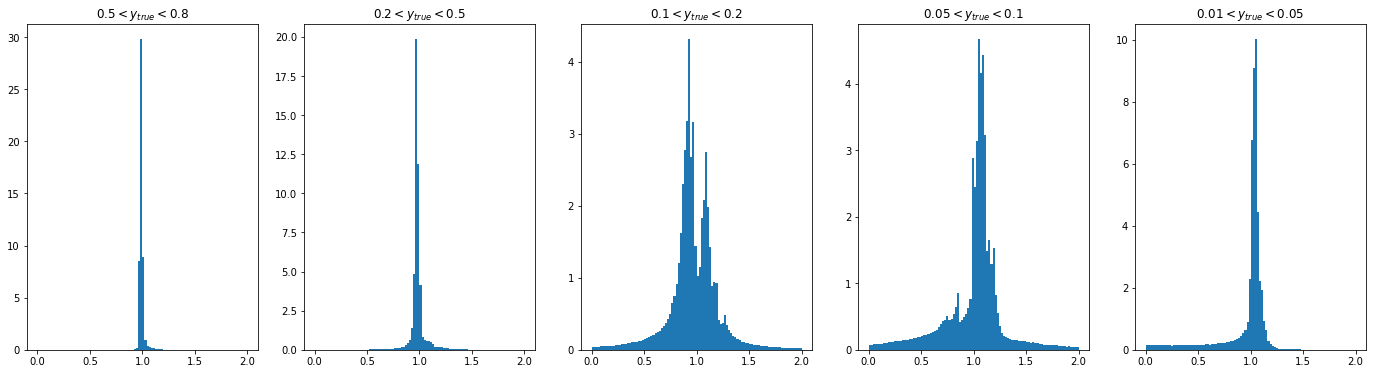

In [20]:
fig,ax = plt.subplots(1,5,figsize=(24,6))

ax[0].hist(mypreds[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

plt.show()

## Conclusions on gen e vars only

Works, but sensitive to size of training sample and learning rate.  Can get artifacts if those are not right.

## Test with reco e vars only

This should be similar to the simple e method results.

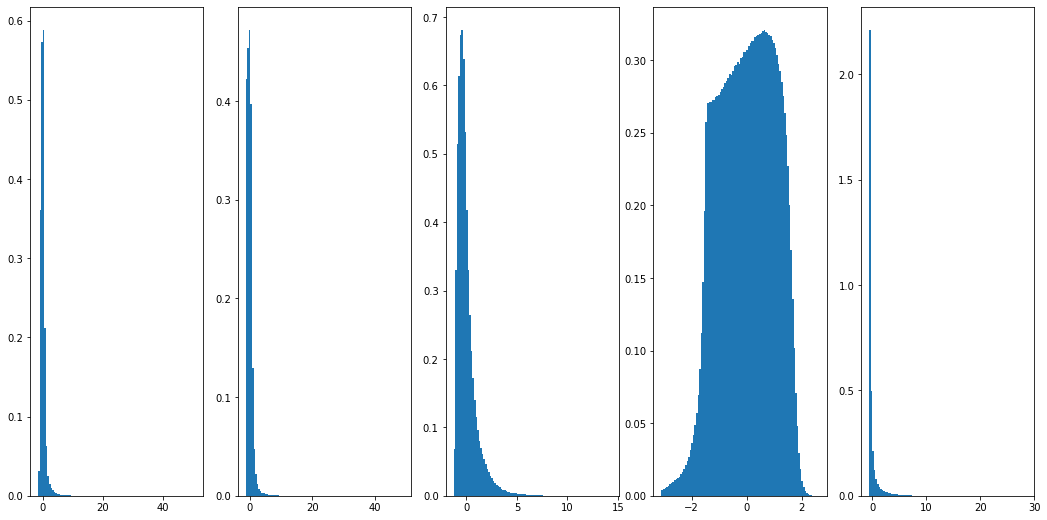

In [21]:
X = np.c_[ 
          pandas_df['e_pz'].to_numpy(),
          pandas_df['e_e'].to_numpy(),
          pandas_df['e_pt'].to_numpy(),
          pandas_df['e_Empz'].to_numpy(),
         ]

Y = pandas_df['gen_x'].to_numpy()

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Y = Y.reshape(-1,1)
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

GY = pandas_df['gen_y'].to_numpy()

X_train, X_test, Y_train, Y_test, GY_train, GY_test = train_test_split( X, Y, GY, test_size=0.5)

fig,ax = plt.subplots(1,5,figsize=(18,9))
for i in range(4):
    ax[i].hist( X[:,i],density=True,bins=100)

ax[4].hist( Y[:,0],density=True,bins=100)
plt.show()

In [22]:
model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='selu'))
model.add(Dense(1, activation='linear'))

#opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval)
myloss = tf.keras.losses.Huber()

model.compile(loss=myloss, optimizer=opt, metrics=['accuracy'])

In [23]:
%%time

hist = model.fit(
    X_train, Y_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X_test,Y_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
5351/5351 [==============================] - 25s 4ms/step - loss: 0.0834 - accuracy: 0.0000e+00 - val_loss: 0.0670 - val_accuracy: 0.0000e+00
Epoch 2/5000
5351/5351 [==============================] - 27s 5ms/step - loss: 0.0702 - accuracy: 0.0000e+00 - val_loss: 0.0674 - val_accuracy: 0.0000e+00
Epoch 3/5000
5351/5351 [==============================] - 31s 6ms/step - loss: 0.0688 - accuracy: 0.0000e+00 - val_loss: 0.0667 - val_accuracy: 0.0000e+00
Epoch 4/5000
5351/5351 [==============================] - 33s 6ms/step - loss: 0.0682 - accuracy: 0.0000e+00 - val_loss: 0.0664 - val_accuracy: 0.0000e+00
Epoch 5/5000
5351/5351 [==============================] - 29s 5ms/step - loss: 0.0678 - accuracy: 0.0000e+00 - val_loss: 0.0663 - val_accuracy: 0.0000e+00
Epoch 6/5000
5351/5351 [==============================] - 32s 6ms/step - loss: 0.0675 - accuracy: 0.0000e+00 - val_loss: 0.0663 - val_accuracy: 0.0000e+00
Epoch 7/5000
5351/5351 [==============================] - 29s 5ms/step

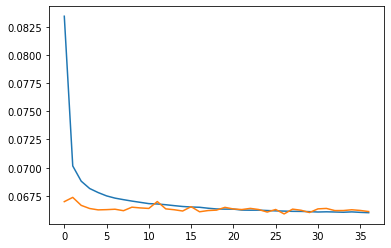

In [24]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [25]:
mypreds = model.predict(X_test,batch_size=1000)

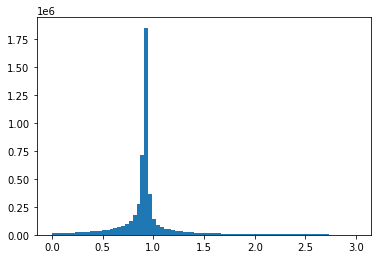

In [26]:
_,_,_=plt.hist(mypreds[:,0]/Y_test[:,0],bins=np.linspace(0,3,80))

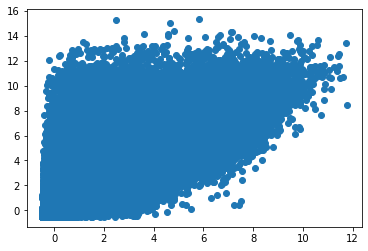

In [27]:
plt.scatter(mypreds[:,0],Y_test[:,0])

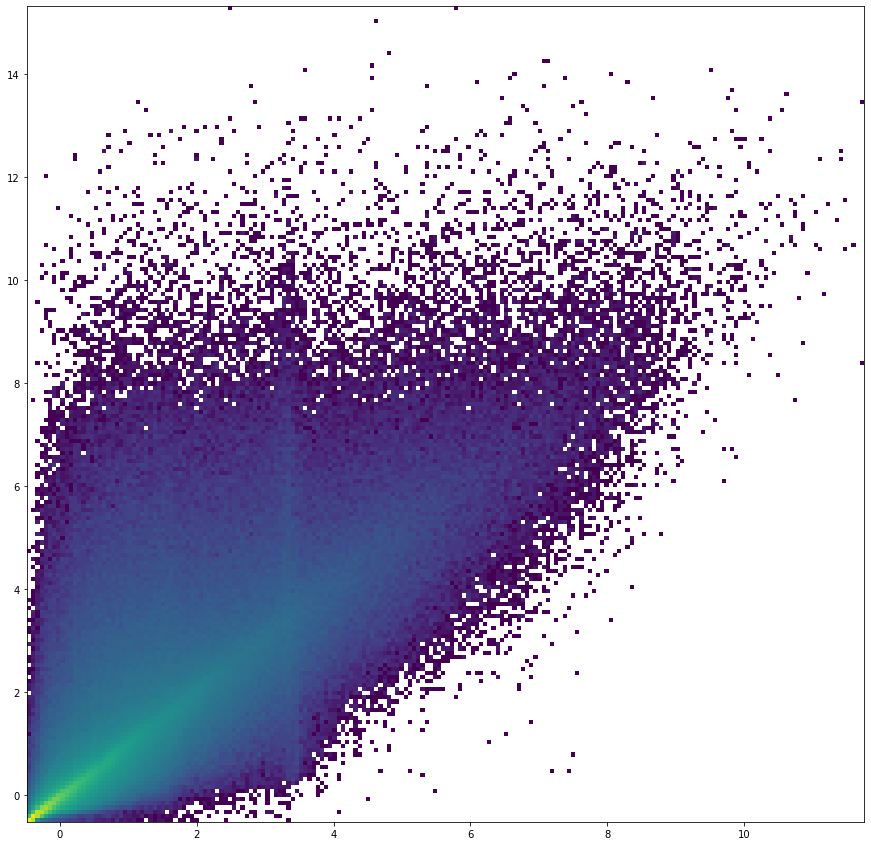

In [28]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.hist2d(mypreds[:,0],Y_test[:,0],bins=200, norm=mpl.colors.LogNorm())
plt.show()

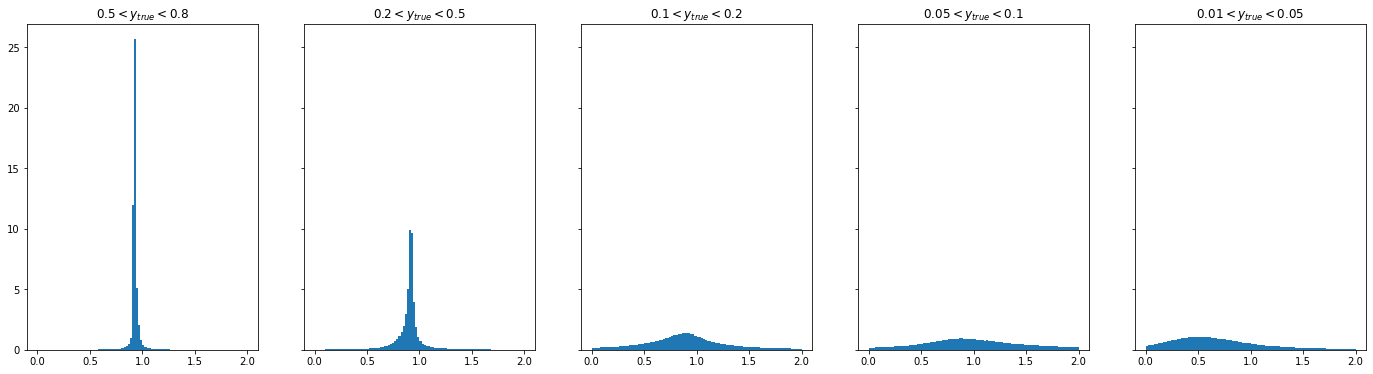

In [29]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(mypreds[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

plt.show()




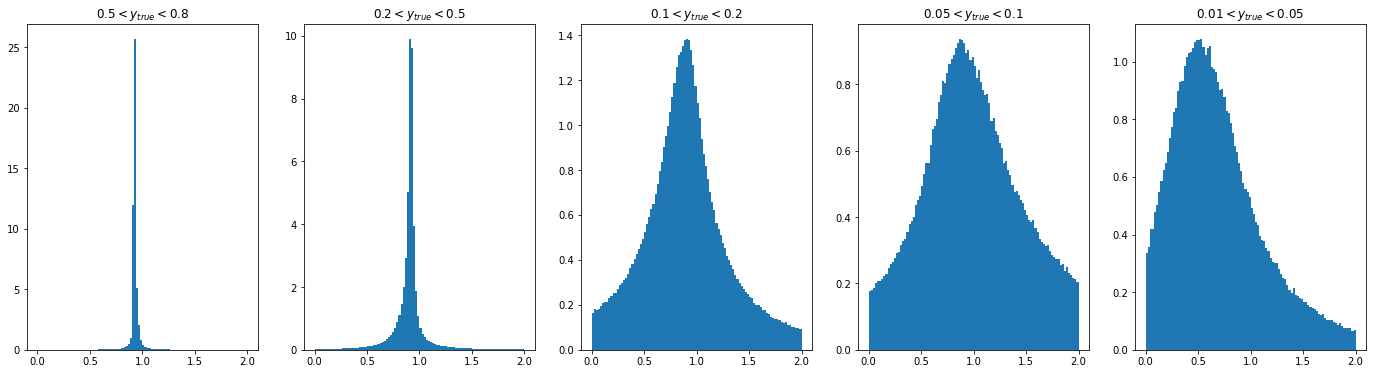

In [30]:
fig,ax = plt.subplots(1,5,figsize=(24,6))

ax[0].hist(mypreds[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

plt.show()

## Conclusions on reco electron vars only

More or less looks as expected.  Resolution gets very poor at low y.

## Now feed in reco electron and reco HFS

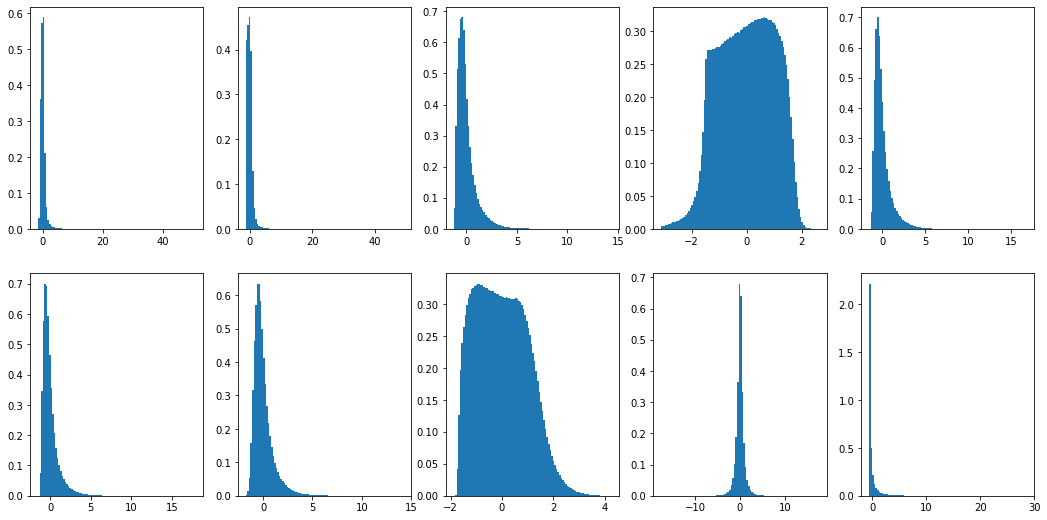

In [31]:
X = np.c_[ 
          pandas_df['e_pz'].to_numpy(),
          pandas_df['e_e'].to_numpy(),
          pandas_df['e_pt'].to_numpy(),
          pandas_df['e_Empz'].to_numpy(),
          pandas_df['HFS_pz'].to_numpy(),
          pandas_df['HFS_E'].to_numpy(),
          pandas_df['HFS_pt'].to_numpy(),
          pandas_df['HFS_Empz'].to_numpy(),
          pandas_df['dphi'].to_numpy(),
         ]

Y = pandas_df['gen_x'].to_numpy()

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Y = Y.reshape(-1,1)
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

GY = pandas_df['gen_y'].to_numpy()

X_train, X_test, Y_train, Y_test, GY_train, GY_test = train_test_split( X, Y, GY, test_size=0.5)

fig,ax = plt.subplots(2,5,figsize=(18,9))
for i in range(5):
    ax[0][i].hist( X[:,i],density=True,bins=100)
for i in range(4):
    ax[1][i].hist( X[:,i+5],density=True,bins=100)

ax[1][4].hist( Y[:,0],density=True,bins=100)
plt.show()

In [32]:
model = Sequential()
model.add(Dense(64, input_dim=9, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='selu'))
model.add(Dense(1, activation='linear'))

#opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval)
myloss = tf.keras.losses.Huber()

model.compile(loss=myloss, optimizer=opt, metrics=['accuracy'])

In [33]:
%%time

hist = model.fit(
    X_train, Y_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X_test,Y_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
5351/5351 [==============================] - 24s 4ms/step - loss: 0.0578 - accuracy: 0.0000e+00 - val_loss: 0.0301 - val_accuracy: 0.0000e+00
Epoch 2/5000
5351/5351 [==============================] - 30s 6ms/step - loss: 0.0346 - accuracy: 0.0000e+00 - val_loss: 0.0239 - val_accuracy: 0.0000e+00
Epoch 3/5000
5351/5351 [==============================] - 33s 6ms/step - loss: 0.0297 - accuracy: 0.0000e+00 - val_loss: 0.0228 - val_accuracy: 0.0000e+00
Epoch 4/5000
5351/5351 [==============================] - 29s 5ms/step - loss: 0.0277 - accuracy: 0.0000e+00 - val_loss: 0.0227 - val_accuracy: 0.0000e+00
Epoch 5/5000
5351/5351 [==============================] - 31s 6ms/step - loss: 0.0266 - accuracy: 0.0000e+00 - val_loss: 0.0226 - val_accuracy: 0.0000e+00
Epoch 6/5000
5351/5351 [==============================] - 33s 6ms/step - loss: 0.0259 - accuracy: 0.0000e+00 - val_loss: 0.0220 - val_accuracy: 0.0000e+00
Epoch 7/5000
5351/5351 [==============================] - 31s 6ms/step

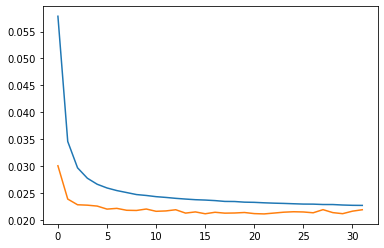

In [34]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

In [35]:
mypreds = model.predict(X_test,batch_size=1000)

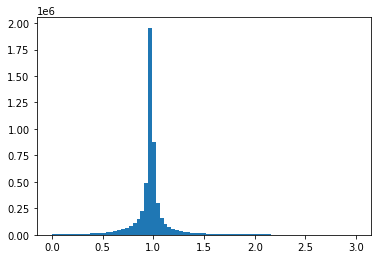

In [36]:
_,_,_=plt.hist(mypreds[:,0]/Y_test[:,0],bins=np.linspace(0,3,80))

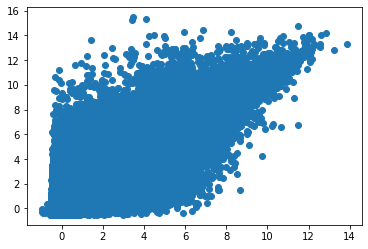

In [37]:
plt.scatter(mypreds[:,0],Y_test[:,0])

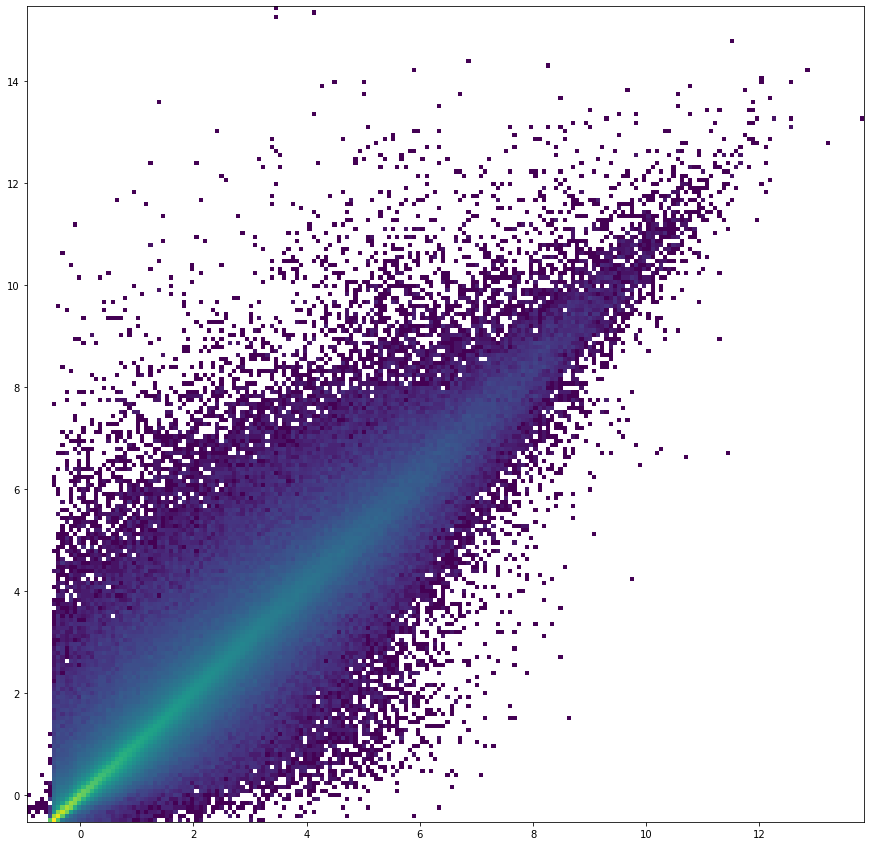

In [38]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.hist2d(mypreds[:,0],Y_test[:,0],bins=200, norm=mpl.colors.LogNorm())
plt.show()

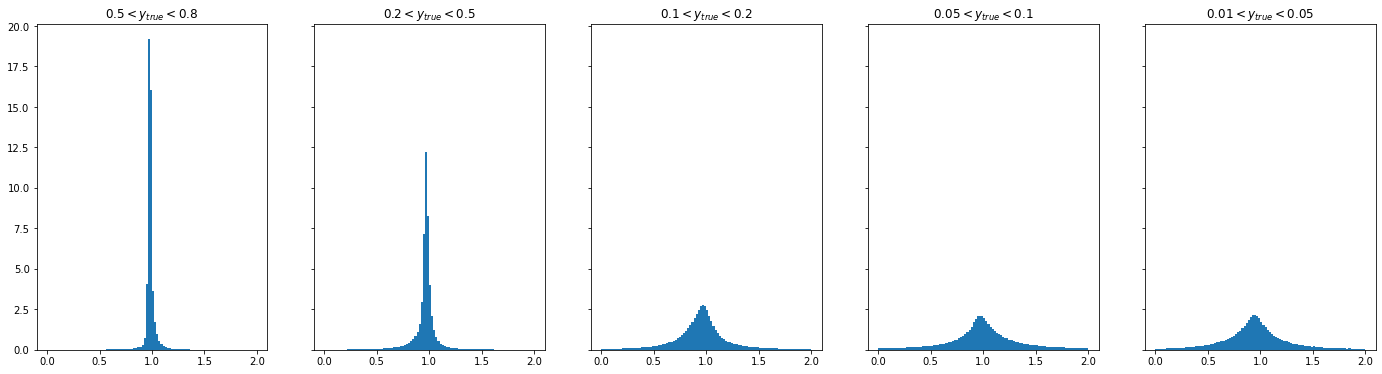

In [39]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(mypreds[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

plt.show()



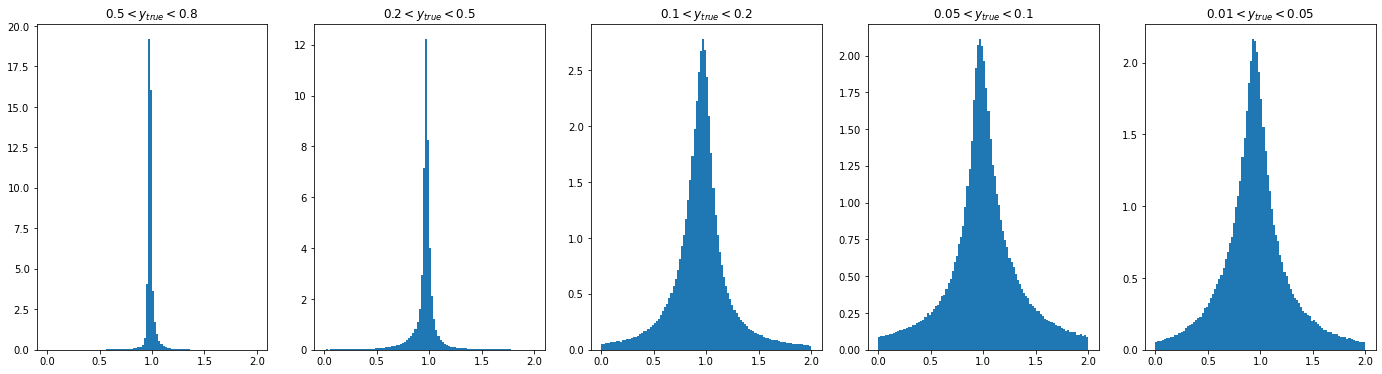

In [40]:
fig,ax = plt.subplots(1,5,figsize=(24,6))

ax[0].hist(mypreds[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

plt.show()

## Conclusions 

Larger training stats don't necessarily give far superior results.


## Standard comparison plots

In [42]:

pandas_df.eval('s = 4*27.6*920', inplace=True)
pandas_df.eval('x_e = Q2_e/(s*y_e)',inplace=True)
pandas_df.eval('x_da = Q2_da/(s*y_da)',inplace=True)
pandas_df.eval('x_sigma = Q2_sigma/(s*y_sigma)',inplace=True)
pandas_df.eval('x_esigma = x_sigma',inplace=True)



pandas_df.eval('gen_x= gen_Q2/(s*gen_y)', inplace=True)   

pandas_df.eval('xe_ratio = x_e/gen_x',inplace=True)
pandas_df.eval('xda_ratio = x_da/gen_x',inplace=True)
pandas_df.eval('xsigma_ratio = x_sigma/gen_x',inplace=True)
pandas_df.eval('xesigma_ratio = x_esigma/gen_x',inplace=True)
        

['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


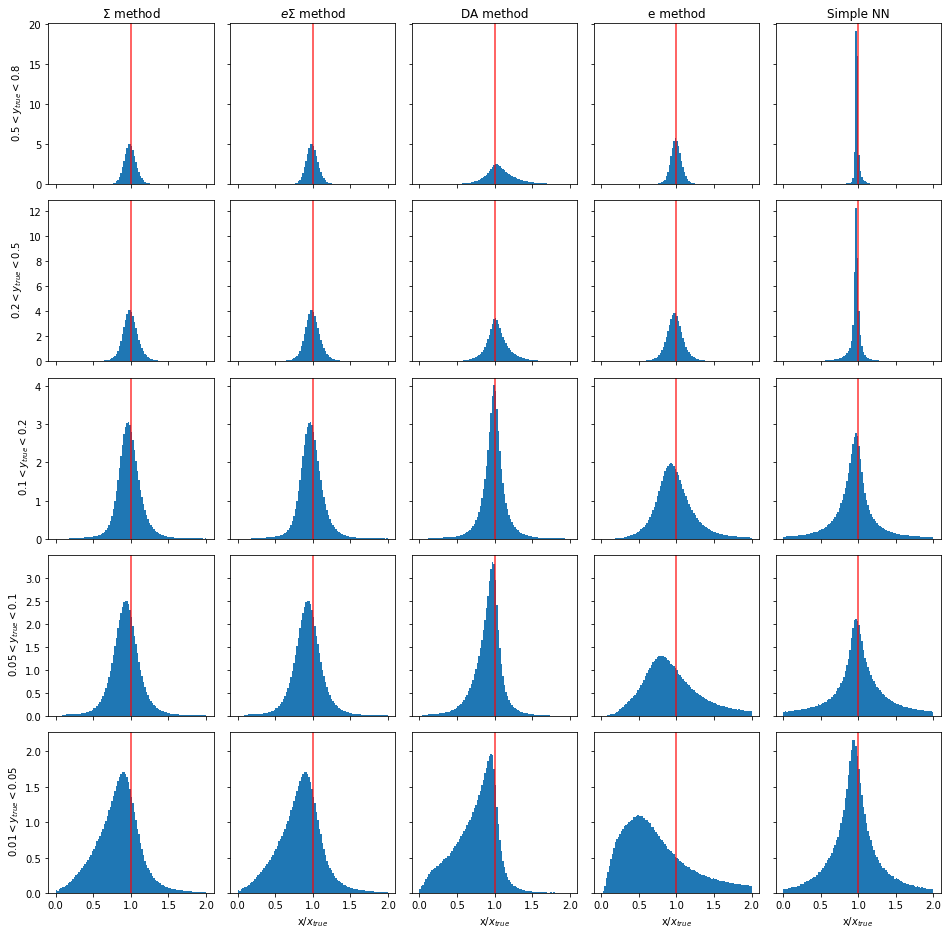

In [43]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)



for i in range(5):
    print(ybins[i])
    ax[0 + 5*i].hist(pandas_df.query(ybins[i])['xsigma_ratio'],density=True,bins=100,range=(0,2))
    ax[1 + 5*i].hist(pandas_df.query(ybins[i])['xesigma_ratio'],density=True,bins=100,range=(0,2))
    ax[2 + 5*i].hist(pandas_df.query(ybins[i])['xda_ratio'],density=True,bins=100,range=(0,2))
    ax[3 + 5*i].hist(pandas_df.query(ybins[i])['xe_ratio'],density=True,bins=100,range=(0,2))

ax[4].hist(mypreds[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[9].hist(mypreds[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[14].hist(mypreds[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[19].hist(mypreds[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[24].hist(mypreds[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))
    
for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[3].set_title('e method')
ax[2].set_title('DA method')
ax[0].set_title('$\Sigma$ method')
ax[1].set_title('$e\Sigma$ method')
ax[4].set_title('Simple NN')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4+1].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8+1+1].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12+1+1+1].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16+1+1+1+1].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'x/$x_{true}$ ')

ax[-2].set_xlabel(r'x/$x_{true}$ ')
ax[-3].set_xlabel(r'x/$x_{true}$ ')
ax[-4].set_xlabel(r'x/$x_{true}$ ')


plt.show()